In [71]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import os
from rasterstats import zonal_stats
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from shapely.errors import ShapelyDeprecationWarning
from glob import glob
from rioxarray.merge import merge_arrays
import rasterio
from shapely.geometry import Polygon, Point
import random
import pickle
import shutil
import importlib
import pandas as pd
from glob import glob
#suppress ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
from p_tqdm import p_map
def recreate_dir(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)
    return path

def load_config(path):
    spec = importlib.util.spec_from_file_location("CFG", path)
    CFG = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(CFG)
    return CFG

In [72]:
DATA_DIR = "data/20230111_kocinka_grodzisko"
CFG = load_config(f"{DATA_DIR}/config.py").OFFSETTING

CACHE_DIR = f"{DATA_DIR}/cache"
GEOTIF_UNCAL_DIR = f"{DATA_DIR}/geotif_raw"
GEOTIF_CAL_DIR = f"{DATA_DIR}/geotif_cal"
TIF_CAL_DIR = f"{DATA_DIR}/tif_cal"
CENTERLINE_PATH = f"{DATA_DIR}/centerline.json"

# Points at water body

In [73]:
#open data/centerline.json
centerline = gpd.read_file(CENTERLINE_PATH)
#reproject centerline to 'epsg:32634'
centerline = centerline.to_crs(CFG.CRS)
#generate points along centerline every 0.1 meters
#distance_delta = 5
distance_delta = 2
distances = np.arange(0, centerline.length[0], distance_delta)
points = [centerline.geometry.interpolate(distance)[0] for distance in distances]
river_pts_gdf = gpd.GeoDataFrame({'geometry': points, 'chainage': distances}, crs=CFG.CRS)
#buffer points to 0.1 meters
river_pts_gdf["geometry"] = river_pts_gdf.buffer(CFG.CENTERLINE_POINTS_BUFFER)
# #load cached footprints
# footprints = pickle.load(open(f"{CACHE_DIR}/footprints.pkl", "rb"))
# #add to footprints a column that contains the indexes of polygons from river_pts_gdf that intersect with the footprint
# footprints["river_pts_idx"] = footprints.geometry.apply(lambda x: river_pts_gdf[river_pts_gdf.intersects(x)].index.values)

In [74]:
#reading footprints from GeoTiffs
geometries = []
names = []
timestamps = []
def get_footprint(path):
    raster = rxr.open_rasterio(path)
    footprints = rasterio.features.shapes((raster != raster.rio.nodata).values.astype(np.int16), transform=raster.rio.transform())
    footprints = [Polygon(geom["coordinates"][0]).simplify(10) for geom, colval in footprints if colval == 1]
    assert len(footprints) == 1, "More than one footprint found"
    name = os.path.basename(path)
    return name, footprints[0]
#use p_map
names, geometries = zip(*p_map(get_footprint, glob(f"{GEOTIF_CAL_DIR}/*.tif")))

footprints = gpd.GeoDataFrame({"name": names, "geometry": geometries})
#write CRS
footprints.crs = CFG.CRS
#add to footprints a column that contains the indexes of polygons from river_pts_gdf that intersect with the footprint
footprints["river_pts_idx"] = footprints.geometry.apply(lambda x: river_pts_gdf[river_pts_gdf.intersects(x)].index.values)

  0%|          | 0/391 [00:00<?, ?it/s]

In [75]:
# if False:#CFG.CACHE and os.path.exists(f"{CACHE_DIR}/exploration_uncal.pkl"):
#     df_uncal = pd.read_pickle(f"{CACHE_DIR}/exploration_uncal.pkl")
# else:
    # temperatures = []
    # chainages = []
    # times = []
def sample_temperatures(footprint):
    time = datetime.strptime(footprint.name.split("_")[1], "%Y%m%d%H%M%S")
    raster = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{footprint.name}")
    geometries = [river_pts_gdf.geometry[idx] for idx in footprint.river_pts_idx]
    stats = zonal_stats(geometries, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
    temperatures = []
    chainages = []
    times = []
    for j, stat in zip(footprint.river_pts_idx, stats):
        if stat["mean"] != None:
            if stat["mean"] < raster.rio.nodata:
                print(footprint.name)
            temperatures.append(stat["mean"])
            chainages.append(river_pts_gdf["chainage"][j])
            times.append(time)
    return temperatures, chainages, times
# for footprint in tqdm(footprints.itertuples(), total=len(footprints)):
#     time = datetime.strptime(footprint.name.split("_")[1], "%Y%m%d%H%M%S")
#     raster = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{footprint.name}")
#     geometries = [river_pts_gdf.geometry[idx] for idx in footprint.river_pts_idx]
#     stats = zonal_stats(geometries, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
#     for j, stat in zip(footprint.river_pts_idx, stats):
#         if stat["mean"] != None:
#             if stat["mean"] < raster.rio.nodata:
#                 print(footprint.name)
#             temperatures.append(stat["mean"])
#             chainages.append(river_pts_gdf["chainage"][j])
#             times.append(time)

temperatures, chainages, times = zip(*p_map(sample_temperatures, list(footprints.itertuples())))
#remove empty lists
#concatenate lists
temperatures = [item for sublist in temperatures for item in sublist]
chainages = [item for sublist in chainages for item in sublist]
times = [item for sublist in times for item in sublist]
assert len(temperatures) == len(chainages) == len(times)

timestamps = [(time.timestamp() - min(times).timestamp())/60 for time in times]
df_uncal = pd.DataFrame({"temperature": temperatures, "chainage": chainages, "time": timestamps})
    #df_uncal.to_pickle(f"{CACHE_DIR}/exploration_uncal.pkl")

  0%|          | 0/391 [00:00<?, ?it/s]

In [76]:
# temperatures = []
# chainages = []
# times = []
def sample_temperatures(footprint):
    time = datetime.strptime(footprint.name.split("_")[1], "%Y%m%d%H%M%S")
    raster = rxr.open_rasterio(f"{GEOTIF_CAL_DIR}/{footprint.name}")
    geometries = [river_pts_gdf.geometry[idx] for idx in footprint.river_pts_idx]
    stats = zonal_stats(geometries, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
    temperatures = []
    chainages = []
    times = []
    for j, stat in zip(footprint.river_pts_idx, stats):
        if stat["mean"] != None:
            if stat["mean"] < raster.rio.nodata:
                print(footprint.name)
            temperatures.append(stat["mean"])
            chainages.append(river_pts_gdf["chainage"][j])
            times.append(time)
    return temperatures, chainages, times

# for footprint in tqdm(footprints.itertuples(), total=len(footprints)):
#     time = datetime.strptime(footprint.name.split("_")[1], "%Y%m%d%H%M%S")
#     raster = rxr.open_rasterio(f"{GEOTIF_CAL_DIR}/{footprint.name}")
#     geometries = [river_pts_gdf.geometry[idx] for idx in footprint.river_pts_idx]
#     stats = zonal_stats(geometries, raster.values[0], stats="mean", affine=raster.rio.transform(), nodata=raster.rio.nodata)
#     for j, stat in zip(footprint.river_pts_idx, stats):
#         if stat["mean"] != None:
#             # if stat["mean"] < raster.rio.nodata:
#             #     print(footprint.name)
#             temperatures.append(stat["mean"])
#             chainages.append(river_pts_gdf["chainage"][j])
#             times.append(time)
temperatures, chainages, times = zip(*p_map(sample_temperatures, list(footprints.itertuples())))
#remove empty lists
#concatenate lists 
temperatures = [item for sublist in temperatures for item in sublist]
chainages = [item for sublist in chainages for item in sublist]
times = [item for sublist in times for item in sublist]
assert len(temperatures) == len(chainages) == len(times)
timestamps = [(time.timestamp() - min(times).timestamp())/60 for time in times]
df_cal = pd.DataFrame({"temperature": temperatures, "chainage": chainages, "time": timestamps})

  0%|          | 0/391 [00:00<?, ?it/s]

In [77]:
#calculate mean and std of temperature for each chainage for uncalibrated and calibrated
uncalibrated_means = df_uncal.groupby("chainage").mean()["temperature"]
calibrated_means = df_cal.groupby("chainage").mean()["temperature"]
uncalibrated_stds = df_uncal.groupby("chainage").std()["temperature"]
calibrated_stds = df_cal.groupby("chainage").std()["temperature"]
print("Point averages")
print(uncalibrated_stds.mean())
print(calibrated_stds.mean())
print("Total")
print(df_uncal["temperature"].std())
print(df_cal["temperature"].std())

Point averages
0.6591302482185107
0.2717481676039539
Total
1.0931629251781743
0.7032079385469355


In [78]:
offset_cal = CFG.WATER_TEMPERATURE - calibrated_means.mean()
df_cal_o = df_cal.copy()
df_cal_o["temperature"] = df_cal_o["temperature"] + offset_cal

offset_uncal = CFG.WATER_TEMPERATURE - uncalibrated_means.mean()
df_uncal_o = df_uncal.copy()
df_uncal_o["temperature"] = df_uncal_o["temperature"] + offset_uncal

In [79]:
def RMSE(A, B):
    return np.sqrt(np.mean((A - B)**2))
def MAE(A, B):
    return np.mean(np.abs(A - B))
#uncal MSE with CFG.WATER_TEMPERATURE as ground truth
rmse_uncal = RMSE(df_uncal_o["temperature"], CFG.WATER_TEMPERATURE)
mae_uncal = MAE(df_uncal_o["temperature"], CFG.WATER_TEMPERATURE)

rmse_cal = RMSE(df_cal_o["temperature"], CFG.WATER_TEMPERATURE)
mae_cal = MAE(df_cal_o["temperature"], CFG.WATER_TEMPERATURE)
print("RMSE")
print(rmse_uncal)
print(rmse_cal)
print("MAE")
print(mae_uncal)
print(mae_cal)


RMSE
1.099733574540856
0.7039250696700753
MAE
0.8318726578937207
0.5195014679805153


In [80]:
pd.DataFrame([DATA_DIR.replace("data/",""), rmse_uncal, rmse_cal, mae_uncal, mae_cal, offset_uncal, offset_cal], index=["Case study", "RMSE uncal", "RMSE cal", "MAE uncal", "MAE cal", "Offset uncal", "Offset cal"]).transpose()

,Case study,RMSE uncal,RMSE cal,MAE uncal,MAE cal,Offset uncal,Offset cal
0,20221220_sudol_krakow,1.099734,0.703925,0.831873,0.519501,-2.606126,-2.097633


In [81]:
# df_uncal["temperature"] = df_uncal["temperature"] + 2.0
# df_cal["temperature"] = df_cal["temperature"] + 2.0

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


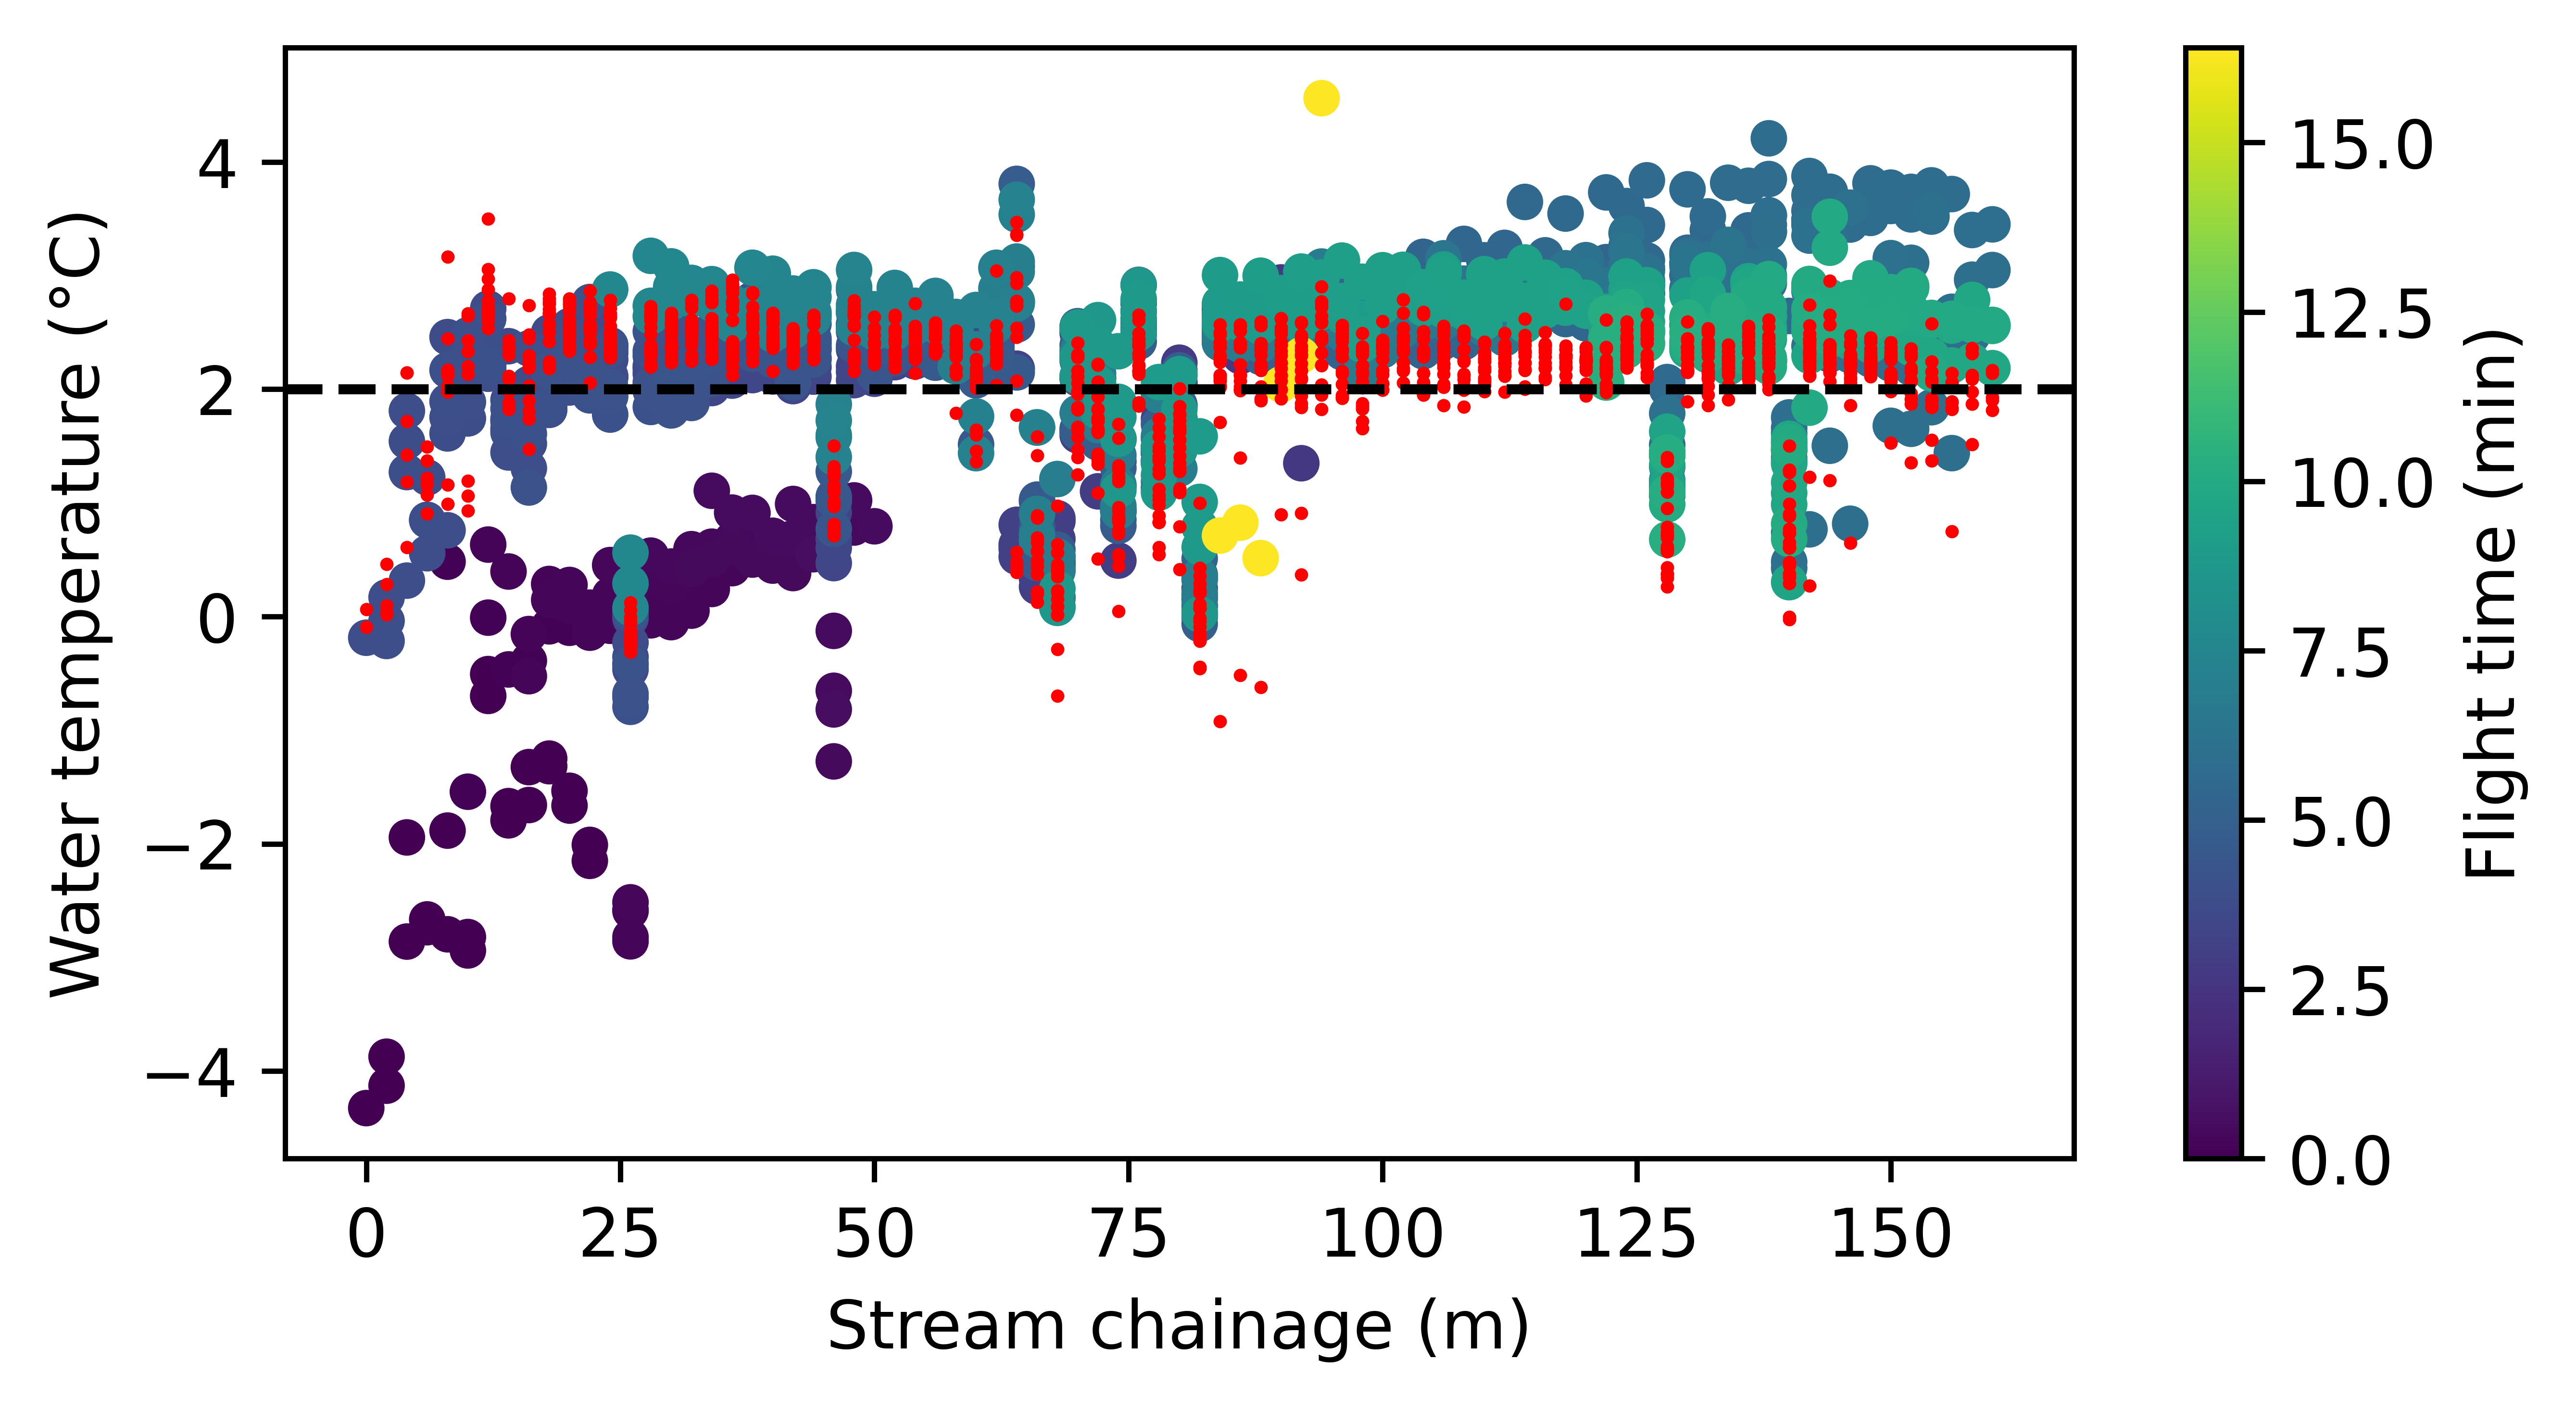

In [82]:
#plot temperature vs chainage vs time (color). Show legend.
plt.rcParams['figure.dpi'] = 1000
fig, ax = plt.subplots(figsize=(6,3))
df_uncal_o.plot.scatter(x="chainage", y="temperature", c="time", colormap="viridis", ax=ax, label="Original")
df_cal_o.plot.scatter(x="chainage", y="temperature", c="red", colormap="viridis", ax=ax, label="Calibrated", s=1)
#df_cal_o.plot.scatter(x="chainage", y="temperature", c="green", colormap="viridis", ax=ax, label="Offsetted", s=1)
#plot line at CFG.WATER_TEMPERATURE
ax.axhline(CFG.WATER_TEMPERATURE, color="black", label="Water temperature", linestyle="--")
#disable legend
ax.legend().remove()
#add to legend
#ax.legend()
#set x label
ax.set_xlabel("Stream chainage (m)")
ax.set_ylabel("Water temperature (°C)")
#update colorbar label
ax.collections[0].colorbar.set_label("Flight time (min)")
#set display dpi
#y min -10
#ax.set_ylim(-2, 8)
plt.show()


In [83]:
# assert False

In [84]:
def apply_offset(name):
    geotif_cal = rxr.open_rasterio(f"{GEOTIF_CAL_DIR}/{name}", masked=True)
    geotif_cal.data = geotif_cal.data + offset_cal
    geotif_cal.rio.to_raster(f"{GEOTIF_CAL_DIR}/{name}")

    geotif_uncal = rxr.open_rasterio(f"{GEOTIF_UNCAL_DIR}/{name}", masked=True)
    geotif_uncal.data = geotif_uncal.data + offset_uncal
    geotif_uncal.rio.to_raster(f"{GEOTIF_UNCAL_DIR}/{name}")
resutlts = p_map(apply_offset, footprints["name"])

  0%|          | 0/391 [00:00<?, ?it/s]